In [166]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

nb_classes = 6

if nb_classes == 9:
    target_classes = ['m','v','bl','c','wmv','v(cy)','bv','sw','t']
elif nb_classes == 6:
    target_classes = ['m','v','bl','c','wmv','v(cy)']
epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

## DenseNet121 trained from scratch

In [167]:
from tensorflow.keras.applications import NASNetLarge

base_model = DenseNet121(include_top=False, weights=None, 
                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes, activation=None)(x)
predictions = Activation('softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [168]:
import math
top_weights_path = f"{created_data_path}/weights/{modelname}.h5"
model.load_weights(top_weights_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Define test set made of 2020 insects

In [169]:
# python organize.py --datadir /home/kalfasyan/data/images/sticky_plates --years 2020

In [170]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_test = pd.DataFrame()
df_test['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/*.jpg"))
df_test['pname'] = df_test['x'].apply(lambda p: p.split('/')[-1][:-4])
df_test['pname'] = df_test['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_test['y_text'] = df_test['x'].apply(lambda x: x.split('/')[-2])

df_test = df_test[df_test.y_text.isin(target_classes)]

df_test['y'] = le.fit_transform(df_test.y_text)

In [171]:
df_test

,x,pname,y_text,y
2505,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w27_3-90_F10_51 mm_ISO160_1-15 s_Incand...,bl,0
2506,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w27_1-60_F10_51 mm_ISO160_1-15 s_Incand...,bl,0
2507,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_Incand...,bl,0
2508,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w26_2-30_F10_51 mm_ISO160_1-15 s_Incand...,bl,0
2509,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w30_4-30_F10_51 mm_ISO160_1-15 s_Incand...,bl,0
...,...,...,...,...
10336,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w27_2-30_F10_51 mm_ISO160_1-15 s_Incand...,m,2
10337,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w27_3-60_F10_51 mm_ISO160_1-15 s_Incand...,m,2
10338,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,m,2
10339,/home/kalfasyan/data/images/sticky_plates/crea...,Herent_w28_2-90_F10_51 mm_ISO160_1-15 s_Incand...,m,2


In [172]:
X_test, y_test = df_test.x, df_test.y

In [173]:
df_test.y.value_counts()

3    2904
1    1768
0    1390
2    1245
5     226
4     147
Name: y, dtype: int64

In [174]:
pred = model.predict(valid_generator(X_test.tolist(), y_test.tolist(), batch_size=batch_size, nb_classes=nb_classes, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)
y_pred = np.argmax(pred, axis=1)

240/240 [==============================] - 9s 39ms/step


In [175]:
def get_labelencoder_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

get_labelencoder_mapping(le)
name_map = dict(zip(le.transform(le.classes_), le.classes_))
inv_name_map = {v: k for k, v in name_map.items()}

print(name_map)

{0: 'bl', 1: 'c', 2: 'm', 3: 'v', 4: 'v(cy)', 5: 'wmv'}


0.5751379372436595


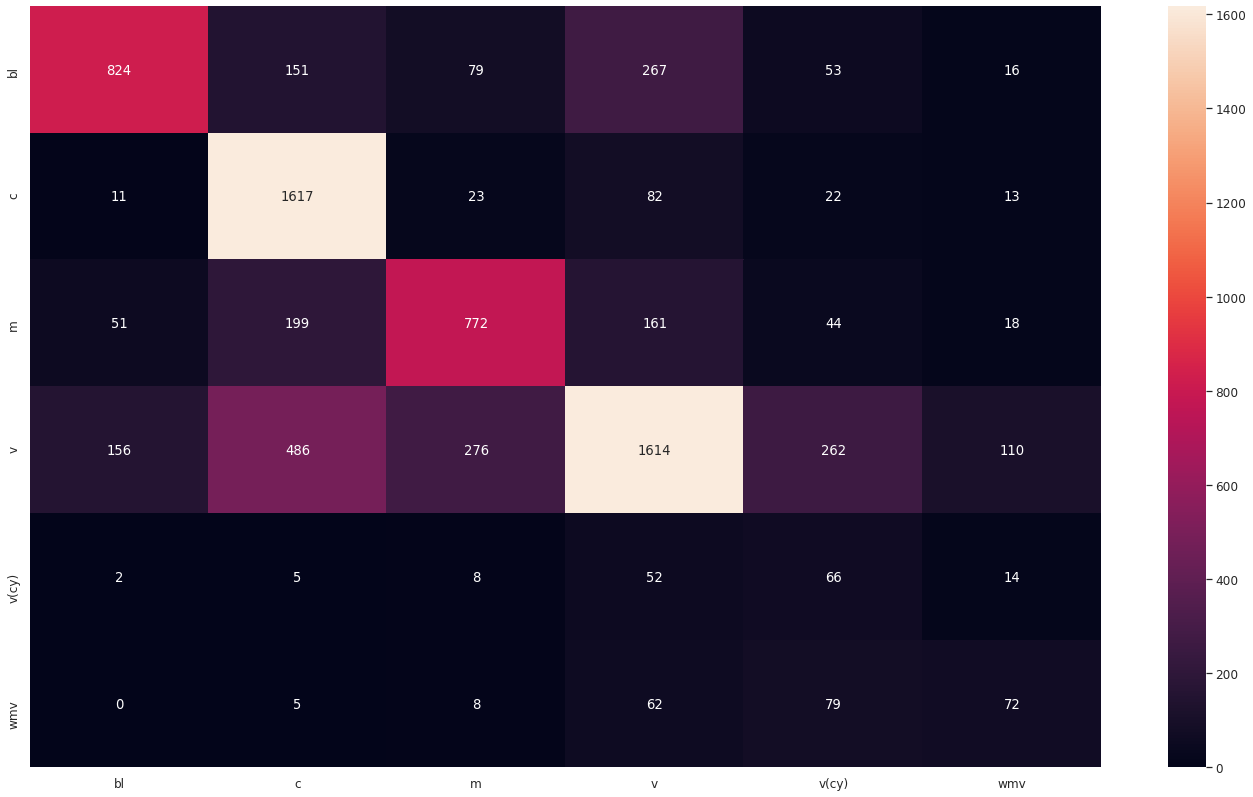

In [176]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(balanced_accuracy_score(y_test, y_pred))


plt.figure(figsize=(24,14))
cm = confusion_matrix(le.fit_transform(y_test), y_pred)
# cm = cm / cm.astype(np.float).sum(axis=0)
sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()), fmt='g')
sns.set(font_scale=1.1)

In [177]:
df_test['pred'] = y_pred
df_wmv = df_test[df_test.y_text=='wmv']
df_wmv.shape

(226, 5)

In [178]:
actual, predicted = [], []
for i, sub in df_wmv.groupby('pname'):
    actual.append(sub.shape[0])
    predicted.append(len(sub[sub.pred==inv_name_map['wmv']]))


In [179]:
data = pd.DataFrame({"actual": actual,"predicted": predicted})

In [180]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

## 6 classes

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


(0.0, 25.0)

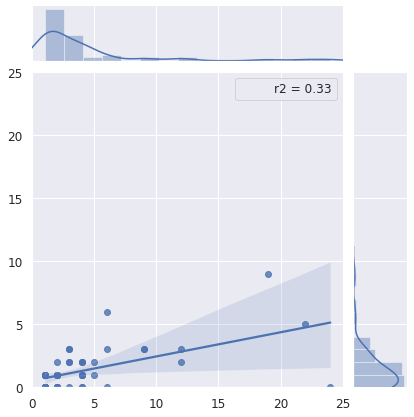

In [181]:
sns.jointplot(actual,predicted, kind="reg", stat_func=r2); plt.ylim(0,25); plt.xlim(0,25)

## 9 classes

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


(0.0, 25.0)

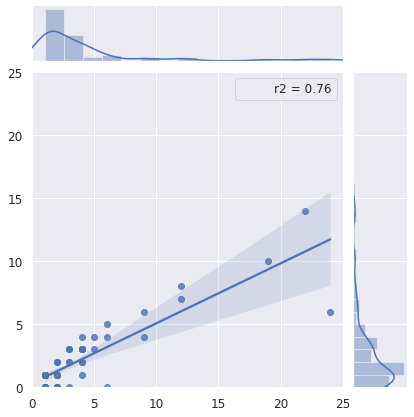

In [165]:
sns.jointplot(actual,predicted, kind="reg", stat_func=r2); plt.ylim(0,25); plt.xlim(0,25)